In this chapter we cover:
1. Examining the CNN architecture

2. Implementing the CNN architecture with Keras

3. Combining a CNN with an LTSM

we’ll implement the CNN architecture as a single-step model,
a multi-step model, and a multi-output model. 

The single-step model will predict the
traffic volume for the next timestep only, the multi-step model will predict the traffic
volume for the next 24 hours, and the multi-output model will predict the temperature
and traffic volume at the next timestep.

A continuation of the previous two chapter scripts, so we will reuse our Datawindow class: 

In [1]:
import pandas as pd
import tensorflow as tf
import numpy as np 
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

In [2]:
train_df = pd.read_csv(r"C:\Users\user\ML Resources-code\Machine-Learning\Deep Learning Time Series Forecasting\train.csv")

test_df = pd.read_csv(r"C:\Users\user\ML Resources-code\Machine-Learning\Deep Learning Time Series Forecasting\test.csv")

val_df = pd.read_csv(r"C:\Users\user\ML Resources-code\Machine-Learning\Deep Learning Time Series Forecasting\val.csv")

print(train_df.shape, test_df.shape, val_df.shape)

(12285, 5) (1756, 5) (3510, 5)


In [35]:
from tensorflow.keras import Model, Sequential

class DataWindow():
    def __init__(self, input_width, label_width, shift,
                 train_df=train_df, val_df = val_df, test_df = test_df, label_columns = None):
        
        self.train_df =train_df
        self.val_df = val_df
        self.test_df = test_df

        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in enumerate(label_columns)}
        self.column_indices = {name: i for i, name in enumerate(train_df.columns)}

        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift

        self.total_window_size = input_width + shift

        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

    def split_to_inputs_labels(self, features):
        inputs = features[:, self.input_slice, :]
        labels = features[:, self.labels_slice, :]
        if self.label_columns is not None:
            labels = tf.stack(
                [labels[:,:,self.column_indices[name]] for name in self.label_columns],
                axis=-1
            )

        inputs.set_shape((None, self.input_width, None))
        labels.set_shape((None, self.label_width, None))

        return inputs, labels
    
    def plot(self, model=None, plot_col='traffic_volume', max_subplots=3):
        inputs, labels = self.sample_batch

        plt.figure(figsize=(12,8))
        plot_col_index = self.column_indices[plot_col]
        max_n = min(max_subplots, len(inputs))

        for n in range(max_n):
            plt.subplot(3, 1, n+1)
            plt.ylabel(f'{plot_col} [scaled]')
            plt.plot(self.input_indices, inputs[n, :, plot_col_index],
                     label='Inputs', marker='.', zorder=-10)
            
            if self.label_columns:
                label_col_index = self.label_columns_indices.get(plot_col, None)
            else:
                label_col_index = plot_col_index

            if label_col_index is None:
                continue

            plt.scatter(self.label_indices, labels[n, :, label_col_index],
                        edgecolors='k', marker='s', label='Labels', c='green',s=64)
            if model is not None:
                predictions = model(inputs)
                plt.scatter(self.label_indices, predictions[n,:,label_col_index],
                            marker='X', edgecolors='k', label='Predictions',c='red', s=64)
                
            if n==0:
                plt.legend()

        plt.xlabel('Time [h]')

    def make_dataset(self, data):
        data = np.array(data, dtype=np.float32)
        ds = tf.keras.preprocessing.timeseries_dataset_from_array(
            data=data,
            targets=None,
            sequence_length=self.total_window_size, 
            sequence_stride=1,
            shuffle=True,
            batch_size=32
        )

        ds = ds.map(self.split_to_inputs_labels)
        return ds
    
    @property
    def train(self):
        return self.make_dataset(self.train_df)

    @property
    def val(self):
        return self.make_dataset(self.val_df)

    @property
    def test(self):
        return self.make_dataset(self.test_df)
    
    @property
    def sample_batch(self):
        result = getattr(self, '_sample_batch', None) 
        if result is None:
            result = next(iter(self.train))
            self._sample_batch = result
        return result
            


In [36]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam 
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import MeanAbsoluteError


def compile_and_fit( model, window, patience=3, max_epochs=50):
    early_stopping = EarlyStopping(monitor='val_loss', patience=patience, mode='min')

    model.compile(loss=MeanSquaredError(),
                  optimizer=Adam(),
                  metrics=[MeanAbsoluteError()])
    
    history = model.fit(window.train, 
                        epochs= max_epochs,
                        validation_data = window.val,
                        callbacks=[early_stopping]) 
    return history 


In [37]:
column_indices = {name: i for i,name in enumerate (train_df.columns)}

CNN

In [38]:
KERNEL_WIDTH = 3
conv_window = DataWindow(input_width= KERNEL_WIDTH, label_width=1, shift=1, label_columns=['traffic_volume'])

In [39]:
LABEL_WIDTH = 24
INPUT_WIDTH = LABEL_WIDTH + KERNEL_WIDTH - 1

wide_conv_window = DataWindow(input_width=INPUT_WIDTH, label_width=LABEL_WIDTH, shift=1, label_columns=['traffic_volume'])

In [40]:
from tensorflow.keras.layers import Dense, Conv1D, LSTM, Lambda, Reshape, RNN, LSTMCell 

cnn_model = Sequential([
    Conv1D(filters=32,  #filters is equivalent to the units of the parameter of the Dense layer 
           kernel_size=(KERNEL_WIDTH),  #only width of the kernel specified, shape of inputs is automatically adapted to
           activation='relu'),
    Dense(32, activation='relu'),
    Dense(1)
])

In [41]:
history = compile_and_fit(cnn_model, conv_window)

val_performance = {}
performance = {}

val_performance['CNN'] = cnn_model.evaluate(conv_window.val)
performance['CNN'] = cnn_model.evaluate(conv_window.test, verbose=0)

Epoch 1/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0447 - mean_absolute_error: 0.1481 - val_loss: 0.0063 - val_mean_absolute_error: 0.0610
Epoch 2/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0059 - mean_absolute_error: 0.0569 - val_loss: 0.0041 - val_mean_absolute_error: 0.0488
Epoch 3/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0041 - mean_absolute_error: 0.0476 - val_loss: 0.0033 - val_mean_absolute_error: 0.0437
Epoch 4/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0036 - mean_absolute_error: 0.0444 - val_loss: 0.0029 - val_mean_absolute_error: 0.0405
Epoch 5/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0034 - mean_absolute_error: 0.0431 - val_loss: 0.0029 - val_mean_absolute_error: 0.0408
Epoch 6/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0031 - mean_absolute_error: 0.0410 - val_loss: 0.0024 - val_mean_absolute_error: 0.0360
Epoch 7/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0029 - mean_absolute_error: 0.0392 - v

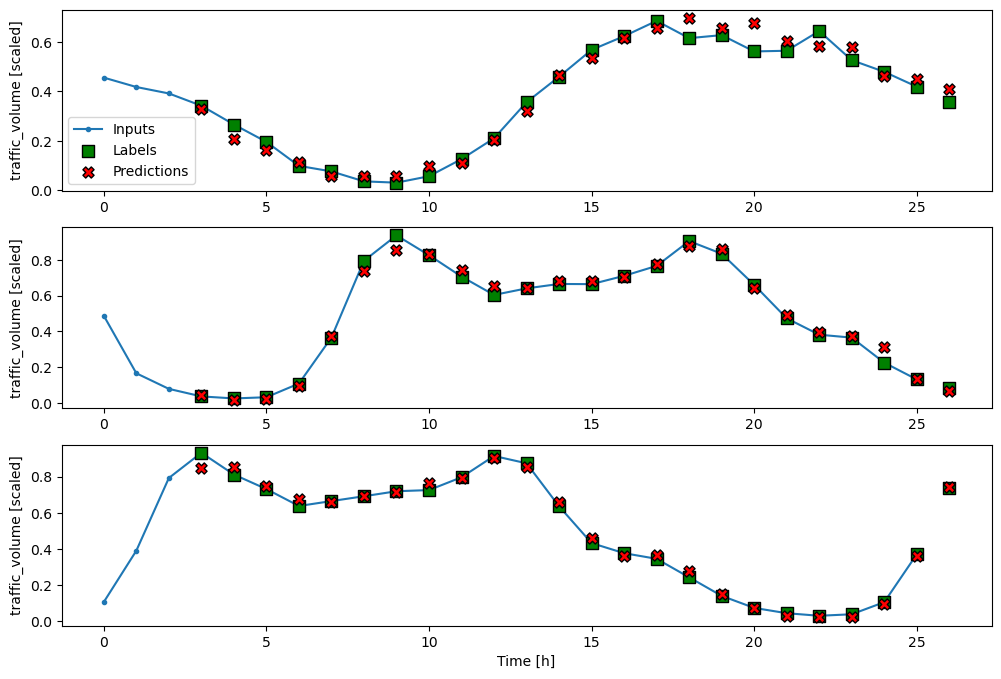

In [42]:
wide_conv_window.plot(cnn_model)


Observation: many predictions overlap labels, meaning that we have
fairly accurate predictions.

The (single-step) model takes three values as an
input(has to be the same length as kernel size), which is why we only see a prediction at the fourth timestep

CNN + LSTM

We saw how the LSTM architecture resulted in the bestperforming
models so far. Thus, it is a reasonable hypothesis that filtering our input
sequence before feeding it to an LSTM might improve the performance. 

In [43]:
cnn_lstm_model = Sequential([
    Conv1D(32, kernel_size = KERNEL_WIDTH, activation='relu'),
    LSTM(32, return_sequences=True),
    LSTM(32, return_sequences=True),
    Dense(1)
])

#fit the model
history = compile_and_fit(cnn_lstm_model, conv_window)

val_performance['CNN + LSTM'] = cnn_lstm_model.evaluate(conv_window.val) 
performance['CNN + LSTM'] = cnn_lstm_model.evaluate(conv_window.test, verbose=0)

Epoch 1/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - loss: 0.0842 - mean_absolute_error: 0.2030 - val_loss: 0.0075 - val_mean_absolute_error: 0.0659
Epoch 2/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0069 - mean_absolute_error: 0.0606 - val_loss: 0.0048 - val_mean_absolute_error: 0.0511
Epoch 3/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0048 - mean_absolute_error: 0.0516 - val_loss: 0.0037 - val_mean_absolute_error: 0.0445
Epoch 4/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0039 - mean_absolute_error: 0.0458 - val_loss: 0.0031 - val_mean_absolute_error: 0.0418
Epoch 5/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0035 - mean_absolute_error: 0.0437 - val_loss: 0.0029 - val_mean_absolute_error: 0.0403
Epoch 6/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0033 - mean_absolute_error: 0.0421 - val_loss: 0.0027 - val_mean_absolute_error: 0.0385
Epoch 7/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0034 - mean_absolute_error: 0.0428 - v

In [44]:
print(performance)

{'CNN': [0.0014269406674429774, 0.02734275534749031], 'CNN + LSTM': [0.0019823266193270683, 0.03389088809490204]}


Observations:

One valuation of our models using the MAE, the CNN does not improve upon the LSTM performance. The combination did not improve the performance either. 

This might be explained by the length of the input sequence. An input sequence of only 3 values might not be sufficient for the CNN to extract valuable features for predictions. 

While a CNN is better than the baseline
model and the linear model, the LSTM remains the best-performing single-step
model for now

-----------------------------------------------------------

Multi-step CNN model

In [45]:
KERNEL_WIDTH = 3
LABEL_WIDTH = 24
INPUT_WIDTH = LABEL_WIDTH + KERNEL_WIDTH - 1 #we use 26 hours of data to predict the next 24 hours

multi_window = DataWindow(input_width=INPUT_WIDTH, label_width=LABEL_WIDTH, shift=24, label_columns=['traffic_volume'])

In [46]:
ms_cnn_model = Sequential([
    Conv1D(32, activation='relu', kernel_size=(KERNEL_WIDTH)),
    Dense(32, activation='relu'),
    Dense(1, kernel_initializer= tf._initializers.zeros),
])

#train the model and store the performance metrics for comparison later 
history = compile_and_fit(ms_cnn_model, multi_window)

ms_val_performance = {}
ms_performance = {}

ms_val_performance['CNN'] = ms_cnn_model.evaluate(multi_window.val)
ms_performance['CNN'] = ms_cnn_model.evaluate(multi_window.test, verbose=0)

Epoch 1/50
383/383 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.0712 - mean_absolute_error: 0.1877 - val_loss: 0.0170 - val_mean_absolute_error: 0.0868
Epoch 2/50
383/383 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0148 - mean_absolute_error: 0.0822 - val_loss: 0.0153 - val_mean_absolute_error: 0.0828
Epoch 3/50
383/383 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0137 - mean_absolute_error: 0.0783 - val_loss: 0.0145 - val_mean_absolute_error: 0.0790
Epoch 4/50
383/383 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0131 - mean_absolute_error: 0.0764 - val_loss: 0.0146 - val_mean_absolute_error: 0.0777
Epoch 5/50
383/383 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0129 - mean_absolute_error: 0.0754 - val_loss: 0.0141 - val_mean_absolute_error: 0.0777
Epoch 6/50
383/383 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0129 - mean_absolute_error: 0.0760 - val_loss: 0.0139 - val_mean_absolute_error: 0.0781
Epoch 7/50
383/383 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0127 - mean_absolute_error: 0.0754 - v

In [51]:
print(ms_performance['CNN'])

[0.008883247151970863, 0.061688367277383804]


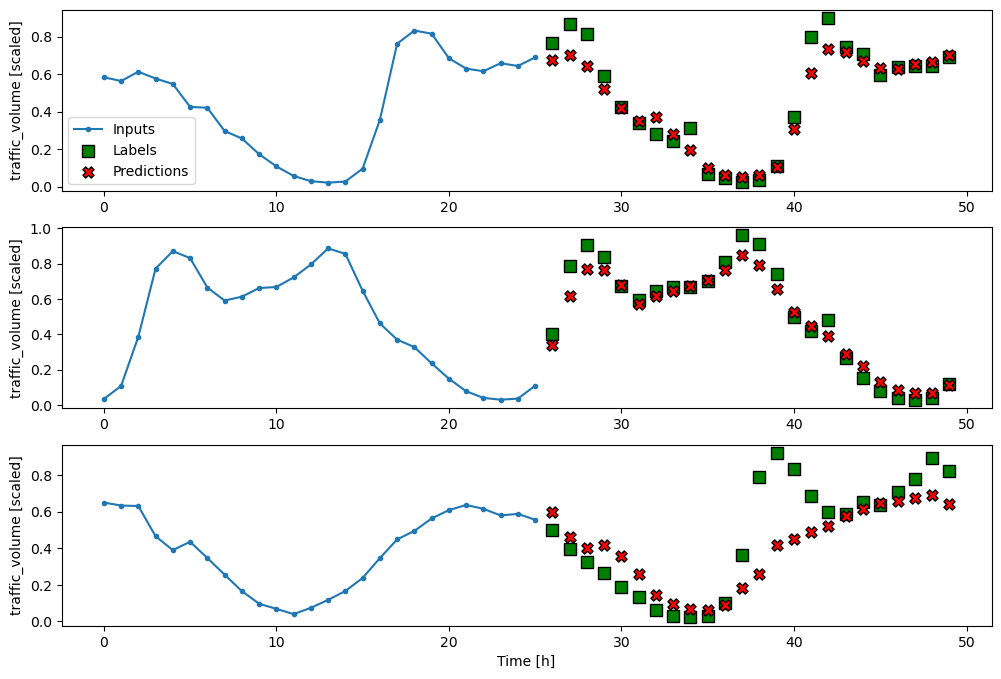

In [48]:
multi_window.plot(ms_cnn_model)

In [49]:
#combine this model with LSTM

ms_cnn_lstm_model = Sequential([
    Conv1D(32, activation='relu', kernel_size=(KERNEL_WIDTH)),
    LSTM(32, return_sequences=True),
    Dense(1, kernel_initializer=tf._initializers.zeros),
])

history = compile_and_fit(ms_cnn_lstm_model, multi_window)

ms_val_performance['CNN + LSTM'] = ms_cnn_lstm_model.evaluate(multi_window.val)
ms_performance['CNN + LSTM'] = ms_cnn_lstm_model.evaluate(multi_window.test, verbose=0)

Epoch 1/50
383/383 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - loss: 0.0762 - mean_absolute_error: 0.1976 - val_loss: 0.0173 - val_mean_absolute_error: 0.0895
Epoch 2/50
383/383 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 0.0148 - mean_absolute_error: 0.0833 - val_loss: 0.0156 - val_mean_absolute_error: 0.0835
Epoch 3/50
383/383 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.0137 - mean_absolute_error: 0.0778 - val_loss: 0.0150 - val_mean_absolute_error: 0.0812
Epoch 4/50
383/383 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 0.0132 - mean_absolute_error: 0.0756 - val_loss: 0.0149 - val_mean_absolute_error: 0.0845
Epoch 5/50
383/383 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 0.0126 - mean_absolute_error: 0.0735 - val_loss: 0.0149 - val_mean_absolute_error: 0.0826
Epoch 6/50
383/383 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 0.0125 - mean_absolute_error: 0.0729 - val_loss: 0.0136 - val_mean_absolute_error: 0.0761
Epoch 7/50
383/383 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 0.0123 - mean_absolute_error: 0.0719 - 

In [50]:
print(ms_performance['CNN + LSTM'])

[0.007751839701086283, 0.054745495319366455]


combining the CNN with an LSTM resulted in the lowest MAE of all

Multi-output CNN model

In [52]:
KERNEL_WIDTH = 3
LABEL_WIDTH = 24
INPUT_WIDTH = LABEL_WIDTH + KERNEL_WIDTH - 1

wide_mo_conv_window = DataWindow(input_width=INPUT_WIDTH, label_width=LABEL_WIDTH, shift=1, label_columns=['temp','traffic_volume'])

In [53]:
mo_cnn_model = Sequential([
    Conv1D(32, activation='relu', kernel_size=(KERNEL_WIDTH)),
    Dense(32, activation='relu'),
    Dense(2)
])

history = compile_and_fit(mo_cnn_model, wide_mo_conv_window)

mo_val_performance = {}
mo_performance = {}

mo_val_performance['CNN'] = mo_cnn_model.evaluate(wide_mo_conv_window.val)
mo_performance['CNN'] = mo_cnn_model.evaluate(wide_mo_conv_window.test, verbose=0)

Epoch 1/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0556 - mean_absolute_error: 0.1592 - val_loss: 0.0032 - val_mean_absolute_error: 0.0375
Epoch 2/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0029 - mean_absolute_error: 0.0348 - val_loss: 0.0017 - val_mean_absolute_error: 0.0282
Epoch 3/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0018 - mean_absolute_error: 0.0279 - val_loss: 0.0013 - val_mean_absolute_error: 0.0248
Epoch 4/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0016 - mean_absolute_error: 0.0258 - val_loss: 0.0012 - val_mean_absolute_error: 0.0237
Epoch 5/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0015 - mean_absolute_error: 0.0245 - val_loss: 0.0012 - val_mean_absolute_error: 0.0226
Epoch 6/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0014 - mean_absolute_error: 0.0236 - val_loss: 0.0011 - val_mean_absolute_error: 0.0224
Epoch 7/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0014 - mean_absolute_error: 0.0230 - v

In [54]:
print(mo_performance['CNN'])

[0.0013051474234089255, 0.025832222774624825]


In [55]:
#combine LSTM architecture and CNN

mo_cnn_lstm_model = Sequential([
    Conv1D(32, activation='relu', kernel_size=(KERNEL_WIDTH)),
    LSTM(32, return_sequences=True),
    Dense(2)
])

history = compile_and_fit(mo_cnn_lstm_model, wide_mo_conv_window)

mo_val_performance['CNN + LSTM'] = mo_cnn_lstm_model.evaluate(wide_mo_conv_window.val)
mo_performance['CNN + LSTM'] = mo_cnn_lstm_model.evaluate(wide_mo_conv_window.test, verbose=0)

Epoch 1/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - loss: 0.0503 - mean_absolute_error: 0.1528 - val_loss: 0.0055 - val_mean_absolute_error: 0.0514
Epoch 2/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 0.0046 - mean_absolute_error: 0.0455 - val_loss: 0.0034 - val_mean_absolute_error: 0.0393
Epoch 3/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 0.0029 - mean_absolute_error: 0.0355 - val_loss: 0.0020 - val_mean_absolute_error: 0.0302
Epoch 4/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 0.0022 - mean_absolute_error: 0.0309 - val_loss: 0.0016 - val_mean_absolute_error: 0.0277
Epoch 5/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 0.0019 - mean_absolute_error: 0.0284 - val_loss: 0.0015 - val_mean_absolute_error: 0.0261
Epoch 6/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 0.0017 - mean_absolute_error: 0.0268 - val_loss: 0.0018 - val_mean_absolute_error: 0.0293
Epoch 7/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 0.0017 - mean_absolute_error: 0.0260 -

In [56]:
print(mo_performance['CNN + LSTM'])

[0.0006682841922156513, 0.01698463410139084]


A slight improvement in MAE is noted, when CNN was combined with LSTM in our multi output model